In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.preprocessing import RobustScaler
from scipy import stats as sp_stats

In [2]:
df=pd.read_csv('data/train.csv',parse_dates=True)
df['label']=np.where(df['roi']==0,0,1)
df

,timestamp,asset_id,roi,indicator_1a,indicator_1b,indicator_1c,indicator_1d,indicator_1e,indicator_1f,return_on_asset,company_age,company_size,revenue,indicator_2a,indicator_2b,indicator_2c,indicator_2d,indicator_2e,indicator_2f,label
0,2023-03-25T16:14:50,c786546e-1788-4dd3-ad7c-66db95294427,False,-18.0,-550.0,-149.0,1243.0,-7576.0,-2204.0,30,15,60,117,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2023-03-25T16:14:50.020000,c786546e-1788-4dd3-ad7c-66db95294427,False,-12.0,-551.0,-149.0,1243.0,-7576.0,-2204.0,30,15,60,117,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2023-03-25T16:14:50.040000,c786546e-1788-4dd3-ad7c-66db95294427,False,-5.0,-556.0,-157.0,1243.0,-7576.0,-2204.0,30,15,60,117,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2023-03-25T16:14:50.060000,c786546e-1788-4dd3-ad7c-66db95294427,False,-6.0,-550.0,-161.0,1399.0,-7575.0,-2268.0,30,15,60,117,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2023-03-25T16:14:50.080000,c786546e-1788-4dd3-ad7c-66db95294427,False,-17.0,-548.0,-154.0,1399.0,-7575.0,-2268.0,30,15,60,117,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202145,2023-11-05T13:13:41.900000,7e67d13b-4b84-42ec-af93-4eda8adc8334,False,4065.0,-3754.0,1312.0,3998.0,-5838.0,-5130.0,30,22,56,172,173.0,278.0,-44.0,-2731.0,-7572.0,2322.0,0
202146,2023-11-05T13:13:41.920000,7e67d13b-4b84-42ec-af93-4eda8adc8334,False,4764.0,-3469.0,644.0,4813.0,-5672.0,-3961.0,30,22,56,172,173.0,278.0,-44.0,-2731.0,-7572.0,2322.0,0
202147,2023-11-05T13:13:41.940000,7e67d13b-4b84-42ec-af93-4eda8adc8334,False,6851.0,-4004.0,800.0,3882.0,-3797.0,1815.0,30,22,56,172,173.0,278.0,-44.0,-2731.0,-7572.0,2322.0,0
202148,2023-11-05T13:13:41.960000,7e67d13b-4b84-42ec-af93-4eda8adc8334,False,5906.0,-5196.0,2223.0,600.0,-3947.0,5521.0,30,22,56,172,173.0,278.0,-44.0,-2731.0,-7572.0,2322.0,0


# 1. Data Preprocessing

In [3]:
df = df.set_index(['asset_id', 'timestamp']).sort_index()
df['time_index'] = df.groupby(level='asset_id').cumcount()

In [4]:
df

roi  \
asset_id                             timestamp                           
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47         False   
                                     2023-08-07T17:00:47.020000  False   
                                     2023-08-07T17:00:47.040000  False   
                                     2023-08-07T17:00:47.060000  False   
                                     2023-08-07T17:00:47.080000  False   
...                                                                ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000  False   
                                     2023-11-05T13:12:43.920000  False   
                                     2023-11-05T13:12:43.940000  False   
                                     2023-11-05T13:12:43.960000  False   
                                     2023-11-05T13:12:43.980000  False   

                                                                 indicator_1a  \
asset_id                             timestamp                                  
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47                143.0   
                                     2023-08-07T17:00:47.020000         161.0   
                                     2023-08-07T17:00:47.040000         169.0   
                                     2023-08-07T17:00:47.060000         174.0   
                                     2023-08-07T17:00:47.080000         152.0   
...                                                                       ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000        -867.0   
                                     2023-11-05T13:12:43.920000       -1397.0   
                                     2023-11-05T13:12:43.940000       -1727.0   
                                     2023-11-05T13:12:43.960000       -1339.0   
                                     2023-11-05T13:12:43.980000       -1339.0   

                                                                 indicator_1b  \
asset_id                             timestamp                                  
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47                254.0   
                                     2023-08-07T17:00:47.020000         247.0   
                                     2023-08-07T17:00:47.040000         193.0   
                                     2023-08-07T17:00:47.060000         199.0   
                                     2023-08-07T17:00:47.080000         244.0   
...                                                                       ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000       -2346.0   
                                     2023-11-05T13:12:43.920000       -2426.0   
                                     2023-11-05T13:12:43.940000       -2355.0   
                                     2023-11-05T13:12:43.960000       -2111.0   
                                     2023-11-05T13:12:43.980000       -2111.0   

                                                                 indicator_1c  \
asset_id                             timestamp                                  
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47               -201.0   
                                     2023-08-07T17:00:47.020000        -262.0   
                                     2023-08-07T17:00:47.040000        -258.0   
                                     2023-08-07T17:00:47.060000        -220.0   
                                     2023-08-07T17:00:47.080000        -202.0   
...                                                                       ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000         470.0   
                                     2023-11-05T13:12:43.920000         396.0   
                                     2023-11-05T13:12:43.940000         232.0   
                                     2023-11-05T13:12:43.960000         133.0   
                        

In [5]:
df['has_nan'] = df.isna().any(axis=1)

In [6]:
magic_indicators = ['indicator_1a', 'indicator_1b', 'indicator_1c', 'indicator_1d',
       'indicator_1e', 'indicator_1f', 'indicator_2a', 'indicator_2b',
       'indicator_2c', 'indicator_2d', 'indicator_2e', 'indicator_2f']

<Axes: xlabel='timestamp'>

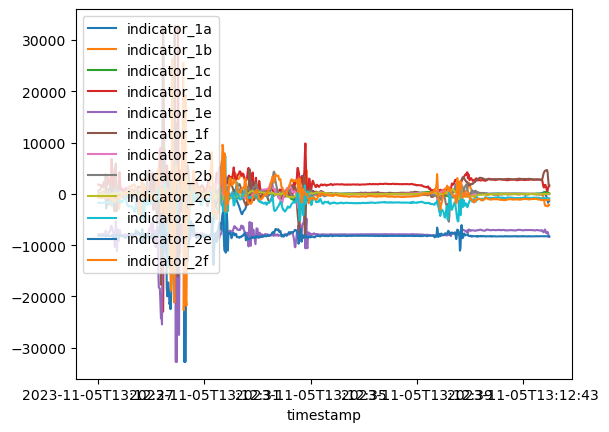

In [7]:
df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',)][magic_indicators].plot()

## 1.a Predicting ROI using rolling std
We predict a fixed window for every asset to be region of interest. <br>
In this case, we only care about Recall, a higher Recall means that we encapsulate most of Region of Interest.<br>
Precision to be low should be Acceptable 

In [8]:
df['Central_Point_roi_estimate'] = -100

def roi_indexing(x, rolling_length= 20):
    temp_df = x.loc[:, magic_indicators].dropna(axis=1).rolling(rolling_length).std().rolling(rolling_length).mean()
    temp_indicator_max_time_recorder = temp_df.idxmax()
    central_point = round(x.loc[temp_indicator_max_time_recorder, 'time_index'].describe()['50%'])#'50%'
    x.loc[:, 'Central_Point_roi_estimate'] = central_point
    return x.loc[:, 'Central_Point_roi_estimate']


In [9]:
window_width = 230# 160
rolling_length = 15
df['Central_Point_roi_estimate'] = df.groupby('asset_id').apply(roi_indexing, rolling_length = rolling_length).reset_index(level=0, drop = True)
df['Time_related_to_roi_central'] = df['time_index'] - df['Central_Point_roi_estimate']
df['Predicted ROI'] = 0
df.loc[(df['Time_related_to_roi_central']>-(window_width/2))&(df['Time_related_to_roi_central']<(window_width/2)), 'Predicted ROI'] = 1
df

roi  \
asset_id                             timestamp                           
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47         False   
                                     2023-08-07T17:00:47.020000  False   
                                     2023-08-07T17:00:47.040000  False   
                                     2023-08-07T17:00:47.060000  False   
                                     2023-08-07T17:00:47.080000  False   
...                                                                ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000  False   
                                     2023-11-05T13:12:43.920000  False   
                                     2023-11-05T13:12:43.940000  False   
                                     2023-11-05T13:12:43.960000  False   
                                     2023-11-05T13:12:43.980000  False   

                                                                 indicator_1a  \
asset_id                             timestamp                                  
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47                143.0   
                                     2023-08-07T17:00:47.020000         161.0   
                                     2023-08-07T17:00:47.040000         169.0   
                                     2023-08-07T17:00:47.060000         174.0   
                                     2023-08-07T17:00:47.080000         152.0   
...                                                                       ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000        -867.0   
                                     2023-11-05T13:12:43.920000       -1397.0   
                                     2023-11-05T13:12:43.940000       -1727.0   
                                     2023-11-05T13:12:43.960000       -1339.0   
                                     2023-11-05T13:12:43.980000       -1339.0   

                                                                 indicator_1b  \
asset_id                             timestamp                                  
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47                254.0   
                                     2023-08-07T17:00:47.020000         247.0   
                                     2023-08-07T17:00:47.040000         193.0   
                                     2023-08-07T17:00:47.060000         199.0   
                                     2023-08-07T17:00:47.080000         244.0   
...                                                                       ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000       -2346.0   
                                     2023-11-05T13:12:43.920000       -2426.0   
                                     2023-11-05T13:12:43.940000       -2355.0   
                                     2023-11-05T13:12:43.960000       -2111.0   
                                     2023-11-05T13:12:43.980000       -2111.0   

                                                                 indicator_1c  \
asset_id                             timestamp                                  
00b82906-7836-428e-b7b1-0f8564989226 2023-08-07T17:00:47               -201.0   
                                     2023-08-07T17:00:47.020000        -262.0   
                                     2023-08-07T17:00:47.040000        -258.0   
                                     2023-08-07T17:00:47.060000        -220.0   
                                     2023-08-07T17:00:47.080000        -202.0   
...                                                                       ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 2023-11-05T13:12:43.900000         470.0   
                                     2023-11-05T13:12:43.920000         396.0   
                                     2023-11-05T13:12:43.940000         232.0   
                                     2023-11-05T13:12:43.960000         133.0   
                        

[[147588  37790]
 [    60  16712]]


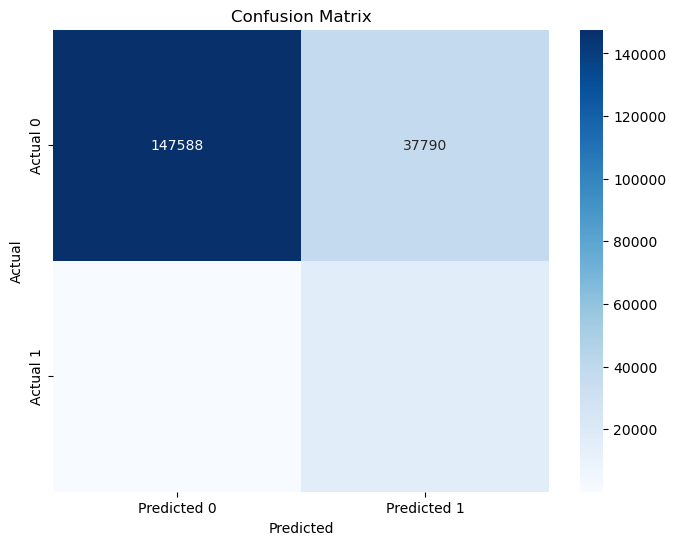

Recall: 0.9964226091104221
Precision (Positive Predictive Value): 0.30663094932296064
F1 Score: 0.46895080955187024


In [10]:

true_labels = df['label']
predicted_labels = df['Predicted ROI']

#Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Recall
recall = recall_score(true_labels, predicted_labels)
print("Recall:", recall)

# Positive Predictive Value (Precision)
precision = precision_score(true_labels, predicted_labels)
print("Precision (Positive Predictive Value):", precision)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)

In [11]:
indicator = [
    'indicator_1a', 'indicator_1b', 'indicator_1c',
    'indicator_1d', 'indicator_1e', 'indicator_1f','indicator_2a', 'indicator_2b', 'indicator_2c',
    'indicator_2d', 'indicator_2e', 'indicator_2f'
]
indicator_statistics = []
def calculate_statistics(group):
    stats = {}
    for column in indicator:
        stats[f'{column}_mean'] = group[column].mean()
        stats[f'{column}_std'] = group[column].std()
        stats[f'{column}_min'] = group[column].min()
        stats[f'{column}_max'] = group[column].max()
        stats[f'{column}_median'] = group[column].median()
        stats[f'{column}_sum'] = group[column].sum()
        stats[f'{column}_Q1'] = group[column].quantile(0.25)
        stats[f'{column}_Q3'] = group[column].quantile(0.75)
        stats[f'{column}_skew'] = group[column].skew()
        stats[f'{column}_kurt'] = group[column].kurt()
        stats[f'{column}_var'] = group[column].var()
        stats[f'{column}_range'] = group[column].max() - group[column].min()
        stats[f'{column}_IQR'] = group[column].quantile(0.75) - group[column].quantile(0.25)
        

    stats['company_age'] = group['company_age'].iloc[0]
    stats['company_size'] = group['company_size'].iloc[0]
    stats['revenue'] = group['revenue'].iloc[0]
    stats['has_nan'] = group['has_nan'].iloc[0]
    
    return pd.Series(stats)
df_stats = df[df['Predicted ROI']==1].groupby('asset_id').apply(calculate_statistics).reset_index()
df_stats['has_nan'] = np.where(df_stats['has_nan'],1,0)
df_stats

,asset_id,indicator_1a_mean,indicator_1a_std,indicator_1a_min,indicator_1a_max,indicator_1a_median,indicator_1a_sum,indicator_1a_Q1,indicator_1a_Q3,indicator_1a_skew,...,indicator_2f_Q3,indicator_2f_skew,indicator_2f_kurt,indicator_2f_var,indicator_2f_range,indicator_2f_IQR,company_age,company_size,revenue,has_nan
0,00b82906-7836-428e-b7b1-0f8564989226,0.157205,2440.507625,-9829.0,15814.0,-172.0,36.0,-1098.0,940.0,2.433164,...,2471.0,0.953188,15.896322,2.234055e+07,54516.0,2976.0,21,54,165,0
1,02c61b56-5241-44f9-bbef-24c112512804,65.109170,1741.471517,-7184.0,12860.0,6.0,14910.0,-501.0,303.0,1.884790,...,1672.0,-0.646990,8.148071,3.483349e+07,61697.0,4007.0,15,55,167,0
2,034da9c2-b8a2-44c5-9c34-e7728b98a51b,126.921397,2196.807674,-11964.0,4406.0,88.0,29065.0,-915.0,1217.0,-1.627308,...,1038.0,0.215872,7.906551,5.341098e+07,65514.0,3205.0,15,58,170,0
3,061556d8-751f-46f0-b479-08ba731c7840,-231.986900,2090.156576,-11154.0,6989.0,-59.0,-53125.0,-1062.0,725.0,-1.389523,...,2302.0,1.977467,13.497850,3.581157e+07,56564.0,4184.0,18,59,182,0
4,06c5017c-d3ec-48c2-8716-0e77e753c884,195.052402,1797.320080,-7905.0,6860.0,151.0,44667.0,-490.0,848.0,-0.236996,...,-431.0,0.641894,9.789033,5.194207e+07,62720.0,2322.0,22,56,164,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,fdcfcede-893e-4f98-aadf-94a49a70ddae,78.764192,1502.490834,-5470.0,6212.0,107.0,18037.0,-482.0,760.0,-0.369370,...,1580.0,3.973780,25.623192,1.826447e+07,41780.0,2624.0,19,57,180,0
234,fe41f443-daa2-4905-a179-56e6bc652f06,36.152838,1860.612585,-9785.0,6556.0,-115.0,8279.0,-487.0,420.0,-0.929159,...,812.0,2.053135,16.483439,2.463686e+07,52579.0,3175.0,21,70,163,0
235,fe63e3b6-dd93-4d63-a3f7-d8f2e49dc318,68.135371,1357.655905,-9506.0,2999.0,111.0,15603.0,-104.0,758.0,-3.177121,...,491.0,-0.382394,13.186875,3.026470e+07,62976.0,2433.0,17,62,184,0
236,ffbe4771-b188-4cda-9e94-96e8a0c45450,-62.847162,1883.758600,-7662.0,8700.0,-22.0,-14392.0,-433.0,214.0,-0.012548,...,3409.0,-0.960187,15.742461,1.917781e+07,53924.0,2941.0,20,70,182,0


## 1.b Standardizing/Scaling the feature

In [12]:
# Standardizeing time positioning
time_scaler = df.groupby('asset_id')['time_index'].tail(1)
time_scaler = time_scaler.droplevel('timestamp')
df['time_scale'] = df.index.get_level_values('asset_id').map(time_scaler)
df['time_index'] = df['time_index']/df['time_scale'] 

In [13]:
# Standardizeing Other Features

In [14]:
def robust_scale(group, columns, scaler_recorder = None, scaler_name = None):

    # remember to assign scaler_name when assign scaler_recorder
    
    scaler = RobustScaler()
    group[columns] = scaler.fit_transform(group[columns].fillna(0))


    if scaler_recorder != None:
        scaler_recorder[scaler_name] = scaler
    
    for col in columns:
        group[f'{col}_center'] = scaler.center_[columns.index(col)]
        group[f'{col}_scale'] = scaler.scale_[columns.index(col)]
    
    return group

In [15]:
df = df.groupby('asset_id').apply(robust_scale, columns=magic_indicators).reset_index(level=0, drop = True)

In [16]:
centers = [f'{col}_center' for col in magic_indicators]
scales = [f'{col}_scale' for col in magic_indicators]

In [17]:
# Standardize, mean, scale, company information across different asset
columns_scaling_info = centers+scales+['company_age', 'company_size', 'revenue'] 
scaling_information = df.groupby('asset_id').head(1)[columns_scaling_info]
scaling_information = scaling_information.droplevel('timestamp')
# Scaling the information across asset to make Neural network trained easier

cross_asset_scaler = {} # to retaint the scaler information for future use
scaling_information = robust_scale(scaling_information, columns_scaling_info, cross_asset_scaler, 'Train Dataset')[columns_scaling_info]

In [18]:
# mapping the information to the main dataframe
for index, name  in enumerate(columns_scaling_info):
    df[name] = df.index.get_level_values('asset_id').map(scaling_information[columns_scaling_info[index]])

In [19]:
df.columns

Index(['roi', 'indicator_1a', 'indicator_1b', 'indicator_1c', 'indicator_1d',
       'indicator_1e', 'indicator_1f', 'return_on_asset', 'company_age',
       'company_size', 'revenue', 'indicator_2a', 'indicator_2b',
       'indicator_2c', 'indicator_2d', 'indicator_2e', 'indicator_2f', 'label',
       'time_index', 'has_nan', 'Central_Point_roi_estimate',
       'Time_related_to_roi_central', 'Predicted ROI', 'time_scale',
       'indicator_1a_center', 'indicator_1a_scale', 'indicator_1b_center',
       'indicator_1b_scale', 'indicator_1c_center', 'indicator_1c_scale',
       'indicator_1d_center', 'indicator_1d_scale', 'indicator_1e_center',
       'indicator_1e_scale', 'indicator_1f_center', 'indicator_1f_scale',
       'indicator_2a_center', 'indicator_2a_scale', 'indicator_2b_center',
       'indicator_2b_scale', 'indicator_2c_center', 'indicator_2c_scale',
       'indicator_2d_center', 'indicator_2d_scale', 'indicator_2e_center',
       'indicator_2e_scale', 'indicator_2f_center'

In [20]:
'''
temp_df = df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',), magic_indicators].rolling(20).std().rolling(20).mean()
temp_indicator_max_time_recorder = temp_df.idxmax()
#df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',)].loc[temp_indicator_max_time_recorder, 'time_index'].describe()
central_point = round(df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',)].loc[temp_indicator_max_time_recorder, 'time_index'].describe()['50%'])
df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',), 'Central_Point_roi_estimate'] = central_point
'''

"\ntemp_df = df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',), magic_indicators].rolling(20).std().rolling(20).mean()\ntemp_indicator_max_time_recorder = temp_df.idxmax()\n#df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',)].loc[temp_indicator_max_time_recorder, 'time_index'].describe()\ncentral_point = round(df.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',)].loc[temp_indicator_max_time_recorder, 'time_index'].describe()['50%'])\ndf.loc[('ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e',), 'Central_Point_roi_estimate'] = central_point\n"

## 1.c Using only ROI Data

In [21]:
df_roi = df.loc[df['Predicted ROI'] == 1].copy()
df_roi = df_roi.drop('roi', axis = 1)

In [22]:
df_roi['Time_Index'] = df_roi.groupby(['asset_id']).cumcount()

Text(0, 0.5, 'Sample Count')

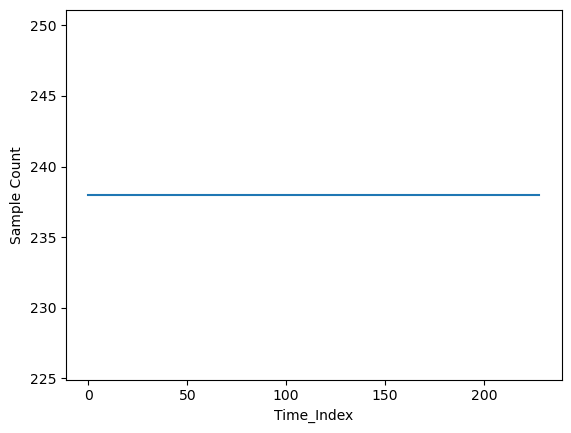

In [23]:
# double check we got same data lengh
df_roi['Time_Index'].value_counts().sort_index().plot()
plt.ylabel('Sample Count')

In [24]:
df_roi = df_roi.reset_index().set_index(['asset_id','Time_Index'])

In [25]:
df_roi

timestamp  \
asset_id                             Time_Index                               
00b82906-7836-428e-b7b1-0f8564989226 0           2023-08-07T17:00:48.880000   
                                     1           2023-08-07T17:00:48.900000   
                                     2           2023-08-07T17:00:48.920000   
                                     3           2023-08-07T17:00:48.940000   
                                     4           2023-08-07T17:00:48.960000   
...                                                                     ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 224         2023-11-05T13:12:32.440000   
                                     225         2023-11-05T13:12:32.460000   
                                     226         2023-11-05T13:12:32.480000   
                                     227         2023-11-05T13:12:32.500000   
                                     228         2023-11-05T13:12:32.520000   

                                                 indicator_1a  indicator_1b  \
asset_id                             Time_Index                               
00b82906-7836-428e-b7b1-0f8564989226 0              -0.250000     -0.356737   
                                     1               0.106707     -0.595757   
                                     2               0.417683     -0.697341   
                                     3               0.557927     -0.516881   
                                     4               0.801829     -0.224081   
...                                                       ...           ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 224           -19.327296      9.068354   
                                     225           -17.930142      8.764557   
                                     226           -17.278137      8.197468   
                                     227           -16.714101      7.564557   
                                     228           -15.880983      6.681013   

                                                 indicator_1c  indicator_1d  \
asset_id                             Time_Index                               
00b82906-7836-428e-b7b1-0f8564989226 0               0.482165     -0.743515   
                                     1               0.388684     -0.819665   
                                     2               0.206642     -0.951883   
                                     3               0.088561     -1.327615   
                                     4               0.098401     -1.871548   
...                                                       ...           ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 224            -3.382249      1.215495   
                                     225            -2.667456      1.170158   
                                     226            -2.369231      1.020947   
                                     227            -2.014201      0.793113   
                                     228            -1.569231      0.618077   

                                                 indicator_1e  indicator_1f  \
asset_id                             Time_Index                               
00b82906-7836-428e-b7b1-0f8564989226 0               1.407134      1.227512   
                                     1               1.249692      1.322111   
                                     2               1.616236      1.483218   
                                     3               1.697417      1.482392   
                                     4               1.726937      1.520397   
...                                                       ...           ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e 224             1.309153     -0.196750   
                                     225             1.741003     -0.411611   
                                     226             1.097195     -0.743580   
                                     227             0.677812     -0.887483   
                                  

In [26]:
df_roi['time_index']

asset_id                              Time_Index
00b82906-7836-428e-b7b1-0f8564989226  0             0.094094
                                      1             0.095095
                                      2             0.096096
                                      3             0.097097
                                      4             0.098098
                                                      ...   
ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e  224           0.320377
                                      225           0.321555
                                      226           0.322733
                                      227           0.323910
                                      228           0.325088
Name: time_index, Length: 54502, dtype: float64

In [27]:
df_roi.to_numpy().shape

(54502, 48)

In [28]:
#features_names = magic_indicators + ['company_age', 'company_size', 'revenue', 'time_index'] 
features_names = magic_indicators + columns_scaling_info+ ['time_index'] 

# Get the shape dimensions
num_first_level = len(df_roi.index.levels[0])
num_second_level = len(df_roi.index.levels[1])
num_columns = len(features_names)

print(num_first_level, num_second_level, num_columns)

# Convert the DataFrame to a NumPy array
array_2d = df_roi[features_names].to_numpy()
# Reshape the 2D array into a 3D array
array_3d = array_2d.reshape((num_first_level, num_second_level, num_columns))

X = array_3d
y = df_roi.groupby('asset_id')['return_on_asset'].head(1).to_numpy()

#save the data to .npy
np.save('X_train_fully_scaled_preprocessed_with_time_index.npy', X)
np.save('y.npy', y)

238 229 40


In [29]:
id_matching = df_roi.index.get_level_values('asset_id').unique()

In [30]:
df_stats = df_stats.set_index('asset_id')

In [31]:
df_stats.loc[id_matching].to_csv('Train_statistics(lite).csv')

In [32]:
id_matching 

Index(['00b82906-7836-428e-b7b1-0f8564989226',
       '02c61b56-5241-44f9-bbef-24c112512804',
       '034da9c2-b8a2-44c5-9c34-e7728b98a51b',
       '061556d8-751f-46f0-b479-08ba731c7840',
       '06c5017c-d3ec-48c2-8716-0e77e753c884',
       '0758bc9b-3bf0-4ea6-a5e4-be92f171413a',
       '081188ea-472d-404f-90bf-19cb9da9347d',
       '091cb0f8-898c-474d-9dfb-faaa66843f6e',
       '09865597-5a47-4206-b244-3ac616d5f964',
       '0a1eae00-3465-4bf4-ad3d-709c1f08f3d4',
       ...
       'f88ae90f-d16b-402b-b875-9909e0b5187b',
       'f97b6394-c744-4300-839c-8eb25d29bf50',
       'fb2bb1cc-b833-431f-a47b-adf74bac2a1d',
       'fbb7bb2d-6951-422c-895a-13cac6fbef14',
       'fda98eb8-16f8-464e-a040-c653825d126c',
       'fdcfcede-893e-4f98-aadf-94a49a70ddae',
       'fe41f443-daa2-4905-a179-56e6bc652f06',
       'fe63e3b6-dd93-4d63-a3f7-d8f2e49dc318',
       'ffbe4771-b188-4cda-9e94-96e8a0c45450',
       'ffe0f381-d9f5-4f03-87a7-e3c12c6bd31e'],
      dtype='object', name='asset_id', length=23

# 2. Dealing with testing data

In [34]:
df_test=pd.read_csv('data/test.csv')

df_test = df_test.set_index(['asset_id', 'timestamp']).sort_index()
df_test['time_index'] = df_test.groupby(level='asset_id').cumcount()

In [35]:
df_test['has_nan'] = df_test.isna().any(axis=1)

## Predicting ROI

In [36]:
df_test['Central_Point_roi_estimate'] = -100
df_test['Central_Point_roi_estimate'] = df_test.groupby('asset_id').apply(roi_indexing, rolling_length = rolling_length).reset_index(level=0, drop = True)
df_test['Time_related_to_roi_central'] = df_test['time_index'] - df_test['Central_Point_roi_estimate']
df_test['Predicted ROI'] = 0
df_test.loc[(df_test['Time_related_to_roi_central']>-(window_width/2))&(df_test['Time_related_to_roi_central']<(window_width/2)), 'Predicted ROI'] = 1
df_test

indicator_1a  \
asset_id                         timestamp                                  
00cdd7262aa74f45b5ff881f6be30577 2023-11-05T12:54:43                 48.0   
                                 2023-11-05T12:54:43.020000         -48.0   
                                 2023-11-05T12:54:43.040000        -117.0   
                                 2023-11-05T12:54:43.060000        -194.0   
                                 2023-11-05T12:54:43.080000        -263.0   
...                                                                   ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 2023-02-27T18:40:58.900000          -7.0   
                                 2023-02-27T18:40:58.920000          -6.0   
                                 2023-02-27T18:40:58.940000         -15.0   
                                 2023-02-27T18:40:58.960000         -13.0   
                                 2023-02-27T18:40:58.980000         -22.0   

                                                             indicator_1b  \
asset_id                         timestamp                                  
00cdd7262aa74f45b5ff881f6be30577 2023-11-05T12:54:43                 18.0   
                                 2023-11-05T12:54:43.020000         -19.0   
                                 2023-11-05T12:54:43.040000         -48.0   
                                 2023-11-05T12:54:43.060000         -38.0   
                                 2023-11-05T12:54:43.080000          11.0   
...                                                                   ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 2023-02-27T18:40:58.900000         -24.0   
                                 2023-02-27T18:40:58.920000         -24.0   
                                 2023-02-27T18:40:58.940000         -25.0   
                                 2023-02-27T18:40:58.960000         -14.0   
                                 2023-02-27T18:40:58.980000          15.0   

                                                             indicator_1c  \
asset_id                         timestamp                                  
00cdd7262aa74f45b5ff881f6be30577 2023-11-05T12:54:43               -135.0   
                                 2023-11-05T12:54:43.020000        -186.0   
                                 2023-11-05T12:54:43.040000        -228.0   
                                 2023-11-05T12:54:43.060000        -236.0   
                                 2023-11-05T12:54:43.080000        -241.0   
...                                                                   ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 2023-02-27T18:40:58.900000          44.0   
                                 2023-02-27T18:40:58.920000          48.0   
                                 2023-02-27T18:40:58.940000          54.0   
                                 2023-02-27T18:40:58.960000          58.0   
                                 2023-02-27T18:40:58.980000          63.0   

                                                             indicator_1d  \
asset_id                         timestamp                                  
00cdd7262aa74f45b5ff881f6be30577 2023-11-05T12:54:43               -642.0   
                                 2023-11-05T12:54:43.020000        -465.0   
                                 2023-11-05T12:54:43.040000        -421.0   
                                 2023-11-05T12:54:43.060000        -619.0   
                                 2023-11-05T12:54:43.080000        -917.0   
...                                                                   ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 2023-02-27T18:40:58.900000        -536.0   
                                 2023-02-27T18:40:58.920000        -554.0   
                                 2023-02-27T18:40:58.940000        -498.0   
                                 2023-02-27T18:40:58.960000        -469.0   
                                 2023-02-27T18:40:58.980000        -551.0   

                                                     

<Axes: xlabel='timestamp'>

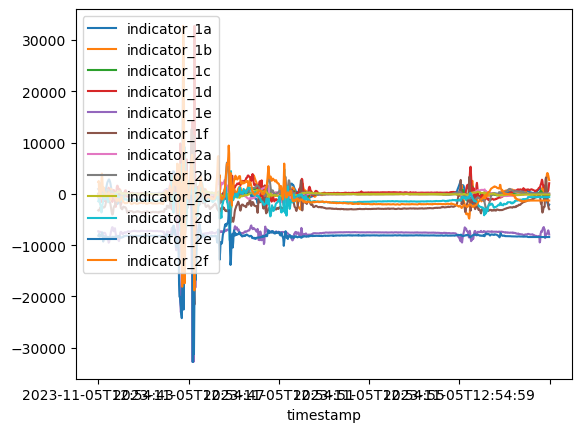

In [37]:
df_test.loc[('00cdd7262aa74f45b5ff881f6be30577',)][magic_indicators].plot()

<Axes: xlabel='timestamp'>

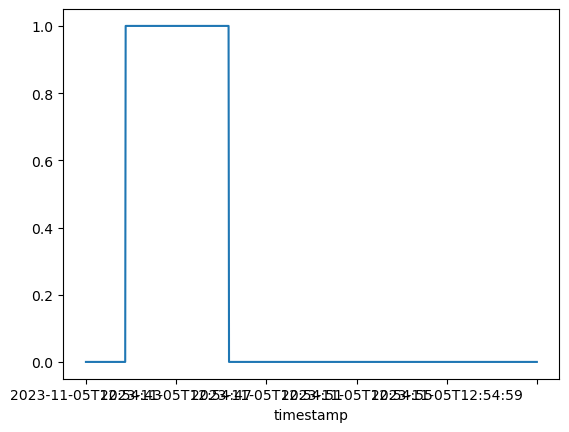

In [38]:
df_test.loc[('00cdd7262aa74f45b5ff881f6be30577',)]['Predicted ROI'].plot()

In [42]:
df_test_stats = df_test[df_test['Predicted ROI']==1].groupby('asset_id').apply(calculate_statistics).reset_index()
df_test_stats['has_nan'] = np.where(df_test_stats['has_nan'],1,0)
df_test_stats

,asset_id,indicator_1a_mean,indicator_1a_std,indicator_1a_min,indicator_1a_max,indicator_1a_median,indicator_1a_sum,indicator_1a_Q1,indicator_1a_Q3,indicator_1a_skew,...,indicator_2f_Q3,indicator_2f_skew,indicator_2f_kurt,indicator_2f_var,indicator_2f_range,indicator_2f_IQR,company_age,company_size,revenue,has_nan
0,00cdd7262aa74f45b5ff881f6be30577,99.296943,1687.265071,-7839.0,6351.0,45.0,22739.0,-200.0,229.0,-0.646075,...,2157.0,1.451706,16.661768,2.335583e+07,51585.0,3930.0,21,88,186,0
1,00ef560475fc4bfebf9dc6c6fce20778,-27.349345,2462.148832,-14295.0,5158.0,206.0,-6263.0,-801.0,1166.0,-1.901640,...,2705.0,0.288536,16.060546,3.047641e+07,65514.0,3823.0,20,63,183,0
2,012ebb1178db45f99e6a538ad83120b2,168.393013,2055.733331,-5492.0,11315.0,-282.0,38562.0,-698.0,704.0,2.100969,...,3512.0,0.537863,15.561140,3.374816e+07,65514.0,3564.0,23,92,183,0
3,025e3e3d187a46699c9328b95d7fb004,-362.737991,2612.362939,-7931.0,16721.0,-686.0,-83067.0,-1740.0,514.0,2.487803,...,2316.0,2.292450,15.646647,1.909864e+07,47983.0,3005.0,21,54,165,0
4,02b965c7262343c5981720073b399ec8,107.305677,1282.180056,-8010.0,9286.0,51.0,24573.0,-176.0,368.0,-0.329017,...,1182.0,-0.563824,10.743431,4.444422e+07,64475.0,2021.0,22,56,172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,f4bc46006e464e68aa97021d8f91b2d7,97.061135,2029.452375,-14723.0,5683.0,56.0,22227.0,-230.0,379.0,-2.391842,...,343.0,2.753614,20.565989,1.568132e+07,45389.0,1875.0,16,64,170,0
121,f5c7b259719944a28e0421980ba68e5b,-25.825328,1662.070611,-6241.0,4829.0,72.0,-5914.0,-637.0,679.0,-0.871147,...,1798.0,1.087085,24.233824,2.480174e+07,65514.0,2144.0,15,58,170,0
122,fbfd778733994ac7b030cb49900d4171,25.751092,921.282194,-5201.0,3172.0,82.0,5897.0,-136.0,371.0,-1.721957,...,907.0,-0.829876,23.453262,2.384113e+07,61785.0,2150.0,23,80,178,0
123,fc41a9abc35c4272b92c6cc846a46c28,-80.934498,1611.151247,-5950.0,5383.0,106.0,-18534.0,-882.0,694.0,-0.557969,...,1507.0,2.458940,18.764054,1.104360e+07,38222.0,2500.0,14,56,170,0


## Standardizing the test data

In [43]:
# Standardizeing time positioning
test_time_scaler = df_test.groupby('asset_id')['time_index'].tail(1)
test_time_scaler = test_time_scaler.droplevel('timestamp')
df_test['time_scale'] = df_test.index.get_level_values('asset_id').map(test_time_scaler)
df_test['time_index'] = df_test['time_index']/df_test['time_scale'] 

In [44]:
# Standardize time series information within assets
df_test = df_test.groupby('asset_id').apply(robust_scale, columns=magic_indicators).reset_index(level=0, drop = True)

In [45]:
test_scaling_information = df_test.groupby('asset_id').head(1)[columns_scaling_info]

In [46]:
# Standardize cross assets information based on the training datatest_scaling_information = df_test.groupby('asset_id').head(1)[columns_scaling_info]
test_scaling_information = test_scaling_information.droplevel('timestamp')
test_scaling_array= cross_asset_scaler['Train Dataset'].transform(test_scaling_information)

In [47]:
test_scaling_information  = pd.DataFrame(test_scaling_array, columns=test_scaling_information.columns, index = test_scaling_information.index)
# mapping the information to the main dataframe
for index, name  in enumerate(columns_scaling_info):
    df_test[name] = df_test.index.get_level_values('asset_id').map(test_scaling_information[columns_scaling_info[index]])

## Using Only ROI Data

Text(0, 0.5, 'Sample Count')

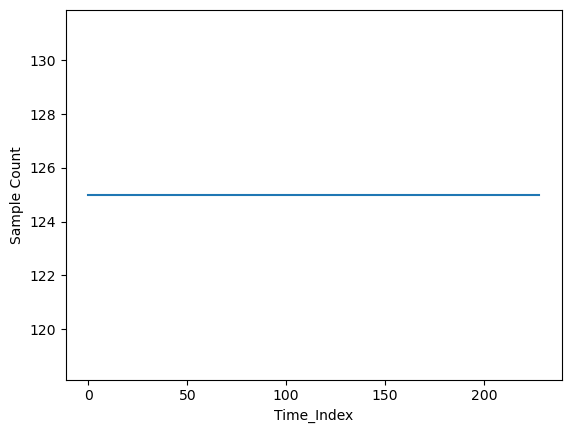

In [48]:
df_test_roi = df_test.loc[df_test['Predicted ROI'] == 1].copy()
df_test_roi['Time_Index'] = df_test_roi.groupby(['asset_id']).cumcount()
# double check we got same data lengh
df_test_roi['Time_Index'].value_counts().sort_index().plot()
plt.ylabel('Sample Count')

In [49]:
df_test_roi = df_test_roi.reset_index().set_index(['asset_id','Time_Index'])

In [50]:
#fillna with mean if previous and next value
# if whole series is lost, use 0

df_test_roi_fillna = df_test_roi.copy()
df_test_roi_fillna.loc[:, magic_indicators] = df_test_roi_fillna.groupby('asset_id')[magic_indicators].apply(lambda group: group.interpolate(method='linear')).reset_index(level=0, drop = True)


# Get the shape dimensions
num_first_level = len(df_test_roi_fillna.index.levels[0])
num_second_level = len(df_test_roi_fillna.index.levels[1])
num_columns = len(features_names)

print(num_first_level, num_second_level, num_columns)

# Convert the DataFrame to a NumPy array
array_2d = df_test_roi_fillna[features_names].to_numpy()
# Reshape the 2D array into a 3D array
array_3d = array_2d.reshape((num_first_level, num_second_level, num_columns))

X = array_3d

125 229 40


In [51]:
X = np.nan_to_num(X, nan=0.0)
assert not np.isnan(X).any(), "X contains NaN values"
assert not np.isnan(y).any(), "y contains NaN values"
assert not np.isinf(X).any(), "X contains Inf values"
assert not np.isinf(y).any(), "y contains Inf values"
#save the data to .npy
np.save('X_test_fully_scaled_preprocessed_with_time_index.npy', X)

In [52]:
df_test_roi_fillna

timestamp  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0           2023-11-05T12:54:44.760000   
                                 1           2023-11-05T12:54:44.780000   
                                 2           2023-11-05T12:54:44.800000   
                                 3           2023-11-05T12:54:44.820000   
                                 4           2023-11-05T12:54:44.840000   
...                                                                 ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224         2023-02-27T18:40:36.240000   
                                 225         2023-02-27T18:40:36.260000   
                                 226         2023-02-27T18:40:36.280000   
                                 227         2023-02-27T18:40:36.300000   
                                 228         2023-02-27T18:40:36.320000   

                                             indicator_1a  indicator_1b  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0              -0.259766     -0.292857   
                                 1              -0.345703     -0.214286   
                                 2              -0.373047     -0.133333   
                                 3              -0.310547     -0.119048   
                                 4              -0.251953     -0.130952   
...                                                   ...           ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224            -0.053775     -0.071247   
                                 225            -0.078594     -0.111959   
                                 226            -0.041365     -0.139101   
                                 227             0.037229     -0.139101   
                                 228             0.012410     -0.071247   

                                             indicator_1c  indicator_1d  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0              -0.173585     -0.177303   
                                 1              -0.060377     -0.180062   
                                 2               0.037736     -0.213177   
                                 3               0.067925     -0.264229   
                                 4               0.052830     -0.291825   
...                                                   ...           ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224             0.116505     -0.009351   
                                 225             0.103560      0.000000   
                                 226             0.077670      0.002338   
                                 227             0.071197      0.027274   
                                 228             0.077670      0.034288   

                                             indicator_1e  indicator_1f  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0               0.739635     -0.664766   
                                 1               0.875622     -0.708096   
                                 2               0.839138     -0.805017   
                                 3               0.719735     -0.798176   
                                 4               0.723051     -0.771950   
...                                                   ...           ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224             0.765152     -0.675962   
                                 225             0.734848     -0.689709   
                                 226             0.765152     -0.665750   
                                 227             0.852273     -0.630793   
                                 228             0.621212     -0.630793   

                                             company_age  company_size  \
asset_id                         Time_Index                              
00cdd7262a

In [53]:
df_test_roi_fillna[features_names].columns

Index(['indicator_1a', 'indicator_1b', 'indicator_1c', 'indicator_1d',
       'indicator_1e', 'indicator_1f', 'indicator_2a', 'indicator_2b',
       'indicator_2c', 'indicator_2d', 'indicator_2e', 'indicator_2f',
       'indicator_1a_center', 'indicator_1b_center', 'indicator_1c_center',
       'indicator_1d_center', 'indicator_1e_center', 'indicator_1f_center',
       'indicator_2a_center', 'indicator_2b_center', 'indicator_2c_center',
       'indicator_2d_center', 'indicator_2e_center', 'indicator_2f_center',
       'indicator_1a_scale', 'indicator_1b_scale', 'indicator_1c_scale',
       'indicator_1d_scale', 'indicator_1e_scale', 'indicator_1f_scale',
       'indicator_2a_scale', 'indicator_2b_scale', 'indicator_2c_scale',
       'indicator_2d_scale', 'indicator_2e_scale', 'indicator_2f_scale',
       'company_age', 'company_size', 'revenue', 'time_index'],
      dtype='object')

In [54]:
pd.DataFrame(df_test_roi_fillna.index.get_level_values('asset_id').unique()).to_csv('asset_id_corresponding_to_X_test.csv')

In [55]:
df_test_roi_fillna[features_names]

indicator_1a  indicator_1b  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0              -0.259766     -0.292857   
                                 1              -0.345703     -0.214286   
                                 2              -0.373047     -0.133333   
                                 3              -0.310547     -0.119048   
                                 4              -0.251953     -0.130952   
...                                                   ...           ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224            -0.053775     -0.071247   
                                 225            -0.078594     -0.111959   
                                 226            -0.041365     -0.139101   
                                 227             0.037229     -0.139101   
                                 228             0.012410     -0.071247   

                                             indicator_1c  indicator_1d  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0              -0.173585     -0.177303   
                                 1              -0.060377     -0.180062   
                                 2               0.037736     -0.213177   
                                 3               0.067925     -0.264229   
                                 4               0.052830     -0.291825   
...                                                   ...           ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224             0.116505     -0.009351   
                                 225             0.103560      0.000000   
                                 226             0.077670      0.002338   
                                 227             0.071197      0.027274   
                                 228             0.077670      0.034288   

                                             indicator_1e  indicator_1f  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0               0.739635     -0.664766   
                                 1               0.875622     -0.708096   
                                 2               0.839138     -0.805017   
                                 3               0.719735     -0.798176   
                                 4               0.723051     -0.771950   
...                                                   ...           ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224             0.765152     -0.675962   
                                 225             0.734848     -0.689709   
                                 226             0.765152     -0.665750   
                                 227             0.852273     -0.630793   
                                 228             0.621212     -0.630793   

                                             indicator_2a  indicator_2b  \
asset_id                         Time_Index                               
00cdd7262aa74f45b5ff881f6be30577 0               0.154440     -0.055096   
                                 1               0.200772     -0.047750   
                                 2               0.226512     -0.216713   
                                 3               0.205920     -0.348944   
                                 4               0.175032     -0.444444   
...                                                   ...           ...   
feaf6db1dc4f48f4bfa3a2f36e323eef 224             0.288330     -0.045169   
                                 225             0.219680     -0.025094   
                                 226             0.210526      0.000000   
                                 227             0.173913      0.007528   
                                 228             0.237986      0.027604   

                                             indicator_2c  indicator_2d  ...  \
asset_id                         Time_Index                  

In [56]:
df_test_stats = df_test_stats.set_index('asset_id')

In [58]:
df_test_stats.loc[df_test_roi_fillna.index.get_level_values('asset_id').unique()].to_csv('Test_statistic(lite).csv')

In [57]:
df_test_stats

,indicator_1a_mean,indicator_1a_std,indicator_1a_min,indicator_1a_max,indicator_1a_median,indicator_1a_sum,indicator_1a_Q1,indicator_1a_Q3,indicator_1a_skew,indicator_1a_kurt,...,indicator_2f_Q3,indicator_2f_skew,indicator_2f_kurt,indicator_2f_var,indicator_2f_range,indicator_2f_IQR,company_age,company_size,revenue,has_nan
asset_id,,,,,,,,,,,,,,,,,,,,,
00cdd7262aa74f45b5ff881f6be30577,99.296943,1687.265071,-7839.0,6351.0,45.0,22739.0,-200.0,229.0,-0.646075,7.028673,...,2157.0,1.451706,16.661768,2.335583e+07,51585.0,3930.0,21,88,186,0
00ef560475fc4bfebf9dc6c6fce20778,-27.349345,2462.148832,-14295.0,5158.0,206.0,-6263.0,-801.0,1166.0,-1.901640,8.028713,...,2705.0,0.288536,16.060546,3.047641e+07,65514.0,3823.0,20,63,183,0
012ebb1178db45f99e6a538ad83120b2,168.393013,2055.733331,-5492.0,11315.0,-282.0,38562.0,-698.0,704.0,2.100969,8.376833,...,3512.0,0.537863,15.561140,3.374816e+07,65514.0,3564.0,23,92,183,0
025e3e3d187a46699c9328b95d7fb004,-362.737991,2612.362939,-7931.0,16721.0,-686.0,-83067.0,-1740.0,514.0,2.487803,13.160617,...,2316.0,2.292450,15.646647,1.909864e+07,47983.0,3005.0,21,54,165,0
02b965c7262343c5981720073b399ec8,107.305677,1282.180056,-8010.0,9286.0,51.0,24573.0,-176.0,368.0,-0.329017,22.696104,...,1182.0,-0.563824,10.743431,4.444422e+07,64475.0,2021.0,22,56,172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f4bc46006e464e68aa97021d8f91b2d7,97.061135,2029.452375,-14723.0,5683.0,56.0,22227.0,-230.0,379.0,-2.391842,17.381721,...,343.0,2.753614,20.565989,1.568132e+07,45389.0,1875.0,16,64,170,0
f5c7b259719944a28e0421980ba68e5b,-25.825328,1662.070611,-6241.0,4829.0,72.0,-5914.0,-637.0,679.0,-0.871147,2.766546,...,1798.0,1.087085,24.233824,2.480174e+07,65514.0,2144.0,15,58,170,0
fbfd778733994ac7b030cb49900d4171,25.751092,921.282194,-5201.0,3172.0,82.0,5897.0,-136.0,371.0,-1.721957,9.230331,...,907.0,-0.829876,23.453262,2.384113e+07,61785.0,2150.0,23,80,178,0
